<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification and KNN

---

Below you will practice KNN classification on a dataset of NHL statistics.

You will be predicting the `Rank` of a team from predictor variables of your choice.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



pd.set_option('max_columns', 99)

### 1. Load the data

In [2]:
# web location:
file_path = '../data/averages.csv'
congress = pd.read_csv(file_path)



In [3]:
# looking at the first rows 
congress.head(20)

congress chamber bioguide last_name state  district        party  votes  \
0          0   house  A000055  Aderholt    AL       4.0   Republican  156.0   
1        115   house  A000055  Aderholt    AL       4.0            R   95.0   
2        116   house  A000055  Aderholt    AL       4.0            R   61.0   
3          0   house  A000367     Amash    MI       3.0  Independent  155.0   
4        115   house  A000367     Amash    MI       3.0            R   96.0   
5        116   house  A000367     Amash    MI       3.0            I   57.0   
6        116   house  A000367     Amash    MI       3.0            R    2.0   
7          0   house  A000369    Amodei    NV       2.0   Republican  155.0   
8        115   house  A000369    Amodei    NV       2.0            R   94.0   
9        116   house  A000369    Amodei    NV       2.0            R   61.0   
10         0   house  A000370     Adams    NC      12.0     Democrat  154.0   
11       115   house  A000370     Adams    NC      12.0            D   92.0   
12       116   house  A000370     Adams    NC      12.0            D   62.0   
13         0   house  A000371   Aguilar    CA      31.0     Democrat  155.0   
14       115   house  A000371   Aguilar    CA      31.0            D   94.0   
15       116   house  A000371   Aguilar    CA      31.0            D   61.0   
16         0   house  A000372     Allen    GA      12.0   Republican  158.0   
17       115   house  A000372     Allen    GA      12.0            R   95.0   
18       116   house  A000372     Allen    GA      12.0            R   63.0   
19         0   house  A000374   Abraham    LA       5.0   Republican  134.0   

    agree_pct  predicted_agree  net_trump_vote  
0    0.974359         0.958389            63.0  
1    0.968421         0.946349            63.0  
2    0.983607         0.977141            63.0  
3    0.625806         0.762262             9.4  
4    0.541667         0.847386             9.4  
5    0.754386         0.656858             9.4  
6    1.000000         0.595826             9.4  
7    0.974194         0.813618            12.3  
8    0.989362         0.876527            12.3  
9    0.950820         0.716675            12.3  
10   0.116883         0.136631           -40.0  
11   0.173913         0.203787           -40.0  
12   0.032258         0.036979           -40.0  
13   0.187097         0.211143           -21.1  
14   0.276596         0.313868           -21.1  
15   0.049180         0.052847           -21.1  
16   0.968354         0.873771            16.2  
17   0.968421         0.905789            16.2  
18   0.968254         0.825490            16.2  
19   0.940299         0.940520            29.4

### 2. Looks like the party column needs some munging - let's: 
    A) Drop the row with a null value in `last_name`
    B) Shorten the longer strings in the party columns i.e. change `Republican` to `R`

In [4]:
### Drop row with null last name 
congress.isnull().sum()

congress             0
chamber              1
bioguide             0
last_name            1
state                1
district           322
party                0
votes                1
agree_pct            1
predicted_agree      0
net_trump_vote       1
dtype: int64

In [5]:
congress.loc[congress['last_name'].isnull()] # .loc uses brackets

congress chamber bioguide last_name state  district party  votes  \
1738       116     NaN  V000133       NaN   NaN       NaN     D    NaN   

      agree_pct  predicted_agree  net_trump_vote  
1738        NaN         0.395036             NaN

In [6]:
congress.loc[1738]

congress                116
chamber                 NaN
bioguide            V000133
last_name               NaN
state                   NaN
district                NaN
party                     D
votes                   NaN
agree_pct               NaN
predicted_agree    0.395036
net_trump_vote          NaN
Name: 1738, dtype: object

In [7]:
congress = congress.drop(1738) # Achieves the same result as code below 

In [8]:
# congress = congress.dropna(subset = ['last_name']) # subset in dropna specifies where to drop nulls

In [9]:
### Clean target column 'party'. .loc is convention for reassigning a new variable
congress.loc[:, 'party'] = congress['party'].map(lambda cell: cell[0]) # lambda defines an in-line function.
# the right side of the colon automatically returns, no need to type 'return'

In [10]:
congress

congress chamber bioguide last_name state  district party  votes  \
0            0   house  A000055  Aderholt    AL       4.0     R  156.0   
1          115   house  A000055  Aderholt    AL       4.0     R   95.0   
2          116   house  A000055  Aderholt    AL       4.0     R   61.0   
3            0   house  A000367     Amash    MI       3.0     I  155.0   
4          115   house  A000367     Amash    MI       3.0     R   96.0   
...        ...     ...      ...       ...   ...       ...   ...    ...   
1733       115  senate  W000817    Warren    MA       NaN     D   84.0   
1734       116  senate  W000817    Warren    MA       NaN     D   18.0   
1735         0  senate  Y000064     Young    IN       NaN     R  114.0   
1736       115  senate  Y000064     Young    IN       NaN     R   84.0   
1737       116  senate  Y000064     Young    IN       NaN     R   30.0   

      agree_pct  predicted_agree  net_trump_vote  
0      0.974359         0.958389       63.000000  
1      0.968421         0.946349       63.000000  
2      0.983607         0.977141       63.000000  
3      0.625806         0.762262        9.400000  
4      0.541667         0.847386        9.400000  
...         ...              ...             ...  
1733   0.130952         0.232881      -27.196706  
1734   0.055556         0.083925      -27.196706  
1735   0.850877         0.811364       19.165194  
1736   0.928571         0.834811       19.165194  
1737   0.633333         0.745711       19.165194  

[1738 rows x 11 columns]

### 3. We are going to be predicting `party` using `agree_pct` and `net_trump_vote` as our X variables. What is the baseline accuracy?

In [51]:
#baseline accuracy is the proportion of the data that is in the most frequent class 
# here it is R's .516110
congress['party'].value_counts(normalize=True) # normalize = True makes them floats

R    0.516110
D    0.479287
I    0.004603
Name: party, dtype: float64

### 4. Set up our X and y and perform a train-test-split

In [66]:
congress = congress.loc[congress['congress'] == 0] # filtering out the non zeros of congress
X = congress[['agree_pct', 'net_trump_vote']] # doublebrackets makes it a data frame
y = congress['party']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=32)

### 5. Scale your data

In [71]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [69]:
X_train_sc

array([[-1.00609778e+00,  3.52613979e-02],
       [ 9.61539076e-01,  1.08581017e+00],
       [ 9.68009903e-01,  9.52494121e-01],
       [-1.16511041e+00, -1.09540946e+00],
       [ 1.00376576e+00,  2.08632408e-01],
       [-1.22879725e+00,  7.15219794e-02],
       [ 8.41667011e-01,  7.01137530e-01],
       [-1.05276682e+00, -7.13025147e-01],
       [-1.26904733e+00, -9.65952620e-02],
       [-1.15776769e+00, -1.47120094e+00],
       [ 1.14595764e+00,  1.36701366e+00],
       [-1.26904733e+00, -6.07539819e-01],
       [-1.05832631e+00, -5.74575654e-01],
       [ 1.02325980e+00,  6.45098450e-01],
       [-5.17279656e-01, -4.59201077e-01],
       [ 1.00349948e+00,  5.85762953e-01],
       [ 1.01837247e+00,  1.63731982e+00],
       [ 1.09811320e+00,  1.35382800e+00],
       [-7.83909166e-01, -9.53969890e-01],
       [-9.61683063e-01, -6.70171732e-01],
       [ 3.00705898e-01, -5.90309264e-02],
       [ 9.21554521e-01,  3.06542446e-01],
       [-1.26904733e+00, -1.92191340e-01],
       [-1.

### 6. Let's visualize this - the black stars are the values in the test set 

Set a random state of 32

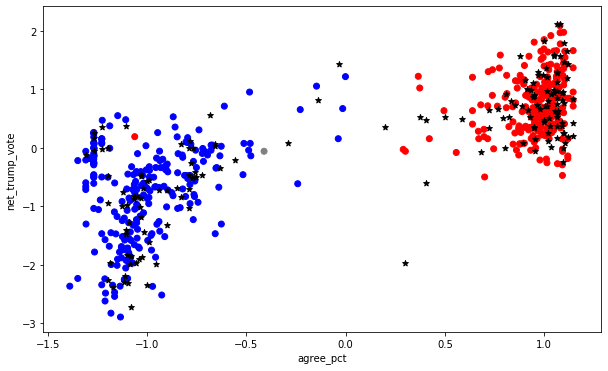

In [72]:
# #plotting trick - map colors to values 
color_dict = {'D':'blue', 'I':'grey', 'R':'red'}

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(X_train_sc[:,0], X_train_sc[:,1], c=y_train.map(color_dict))
ax.scatter(X_test_sc[:,0], X_test_sc[:, 1], color = 'black', marker='*')
ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1]);

### 6. Fit a `KNeighborsClassifier` with k=5
Evauluate your performance on train and test

In [73]:
## code 
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_sc, y_train)
knn5.score(X_train_sc, y_train)

0.9938271604938271

In [74]:
### fit and score on both train and test 
knn5.score(X_test_sc, y_test) # to get a sscore you need to compare predictions to true values

0.9876543209876543

In [75]:
### save predictions
y_test_pred = knn5.predict(X_test_sc)

### Teaser - Confusion Matrix 

In [76]:
def make_pretty_conmat(predictions, true_values, classes):
    print(f'Accuracy score: {round(accuracy_score(true_values, predictions), 4)}')
    cols = 'Predicted ' + classes
    indices = 'Actual ' + classes
    conmat = confusion_matrix(y_test, y_test_pred, labels=classes)
    display(pd.DataFrame(conmat, columns=cols, index=indices))


In [77]:
make_pretty_conmat(y_test_pred, y_test, knn5.classes_)

Accuracy score: 0.9877


Predicted D  Predicted I  Predicted R
Actual D           70            0            0
Actual I            0            0            1
Actual R            1            0           90

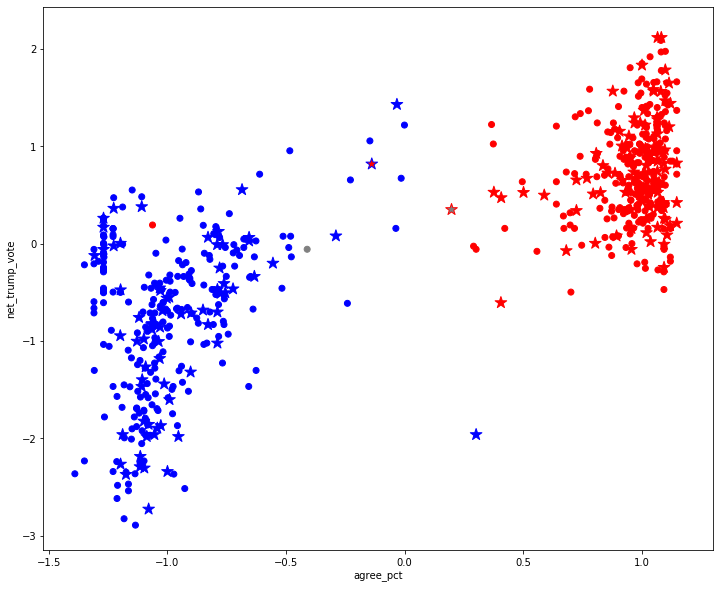

In [78]:
# plotting trick - map colors to values 
color_dict = {'D':'blue', 'I':'grey', 'R':'red'}

fig, ax = plt.subplots(figsize=(12,10))

ax.scatter(X_train_sc[:,0], X_train_sc[:,1], c=y_train.map(color_dict))
ax.scatter(X_test_sc[:,0], X_test_sc[:, 1], color = [color_dict[pred] for pred in y_test_pred], marker='*', \
          facecolors=[color_dict[party] for party in y_test], s=150)
ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1]);

### 7. Fit a `KNeighborsClassifier` with k=1
Evauluate your performance on train and test

In [236]:
### can we turn our code from before into a function?


### 8. Fit a `KNeighborsClassifier` with k= number of observations in your training set (why is this the max)?
Evauluate your performance on train and test

In [8]:
#code 


### 9. Manual parameter tuning - loop through all values of K and evaluate the model on your test set - plot your results 

might need to take steps of 5 for speed

In [9]:
# A:
